In [41]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys
import h5py
from torch.optim import lr_scheduler

sys.path.append("../")
sys.path.append("../..")
from metric import *
from util import *
from model.pinn import PINNs

# 无粘Burgers方程: u_t + u*u_x = 0
# IC:u(x, 0) = alpha + beta*sin(x)
# BC:u(0, t) = u(2π, t)

In [42]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:1'

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [43]:
# get data
# 几何区域：0<=x<=2*pi, 0<=t<=1
# 离散化：101*101网格
# res: 所有散点坐标
# b_left, b_right, b_upper, b_lower：边界点坐标

res, b_init, b_end, b_left, b_right = get_data([-1, 1], [0, 0.6], 101, 101) 
res_test, _, _, _, _ = get_data([-1, 1], [0, 0.6], 101, 101) 

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_init = torch.tensor(b_init, dtype=torch.float32, requires_grad=True).to(device)  # init
b_end = torch.tensor(b_end, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)  # right
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)  # left

# 分别提取散点的x t坐标 --> 列表
x_res, t_res = res[:,0:1], res[:,1:2]
x_init, t_init = b_init[:,0:1], b_init[:,1:2]
x_end, t_end = b_end[:,0:1], b_end[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]

print('res shape: ', res.shape, 'b_left shape: ', b_left.shape, 'b_right shape: ', b_right.shape, 'b_upper shape: ', b_init.shape, 'b_lower shape: ', b_end.shape)

res shape:  torch.Size([10201, 2]) b_left shape:  torch.Size([101, 2]) b_right shape:  torch.Size([101, 2]) b_upper shape:  torch.Size([101, 2]) b_lower shape:  torch.Size([101, 2])


In [44]:
# Train PINNs -- MLP
model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
# optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = lr_scheduler.ExponentialLR(optim, gamma=0.9, verbose=True)

print(model)
print(get_n_params(model))  # 总的参数量

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


/tmp/ipykernel_1182351/1660943584.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [45]:
# trian
loss_track = []
step_size = 5000

for i in tqdm(range(100000)):
    optim.zero_grad()

    pred_res = model(x_res, t_res)  # (n, 1)
    pred_init = model(x_init, t_init)  # init
    pred_left = model(x_left, t_left)  # right
    pred_right = model(x_right, t_right)  # left

    u = pred_res
    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]  # (n, 1)
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

    # GA_PINNs：计算权重，乘以每个残差点的res
    alpha = 1
    beta = 1.25
    Lambda = ( 1 / (1 +  alpha * torch.abs(u_x)**beta ) ) # Works fine

    loss_res = torch.mean(Lambda * ((u_t + u * u_x) ** 2))
    # loss_bc = torch.mean((pred_left - 1) ** 2 + (pred_right) ** 2)  # 边界：u(0, t) = 1, t>=0; u(1, t) = 0, t>=0
    # loss_ic = torch.mean(torch.where(x_init <= 0, (pred_init-1) ** 2, pred_init ** 2))  # 初值：u(x, 0) = 1, x<=0; u(x, 0) = 0, x>0
    # print('loss: ', loss_res, loss_bc, loss_ic)
    loss_ic = torch.mean(torch.where(x_init <= 0, (pred_init-1) ** 2, (pred_init+1) ** 2))
    loss_bcL = torch.mean((pred_left - 1) ** 2)
    loss_bcR = torch.mean((pred_right + 1) ** 2)
    loss_bc = loss_bcL + loss_bcR

    loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

    loss = loss_res + loss_bc + loss_ic
    
    loss.backward()
    optim.step()  # 参数更新

    if (i+1) % step_size == 0:
        scheduler.step()

    with torch.no_grad():
        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])
    
    if i % 5000 == 0:
        print('Iter %d, res: %.5e, Lossic: %.5e, Lossbc: %.5e' % (i, loss_res.item(), loss_ic.item(), loss_bc.item()))


  0%|          | 0/100000 [00:00<?, ?it/s]

Iter 0, res: 8.68415e-03, Lossic: 1.18004e+00, Lossbc: 2.71049e+00


  5%|▌         | 5007/100000 [01:39<31:25, 50.39it/s]

Iter 5000, res: 1.36075e-02, Lossic: 7.18828e-03, Lossbc: 3.05794e-04


 10%|█         | 10008/100000 [03:19<30:31, 49.14it/s]

Iter 10000, res: 2.73879e-02, Lossic: 1.74456e-02, Lossbc: 9.57211e-06


 15%|█▌        | 15010/100000 [05:05<31:13, 45.36it/s]

Iter 15000, res: 4.28013e-02, Lossic: 4.70032e-02, Lossbc: 2.33867e-04


 20%|██        | 20008/100000 [06:52<28:40, 46.49it/s]

Iter 20000, res: 7.95116e-03, Lossic: 1.01345e-02, Lossbc: 2.43841e-06


 25%|██▌       | 25006/100000 [08:39<26:08, 47.80it/s]

Iter 25000, res: 1.41355e-02, Lossic: 2.10530e-02, Lossbc: 2.97520e-05


 30%|███       | 30006/100000 [10:27<24:28, 47.67it/s]

Iter 30000, res: 2.12903e-02, Lossic: 1.88062e-02, Lossbc: 5.57524e-06


 35%|███▌      | 35009/100000 [12:17<23:10, 46.73it/s]

Iter 35000, res: 9.65651e-02, Lossic: 5.27336e-02, Lossbc: 1.12860e-03


 40%|████      | 40007/100000 [14:05<21:54, 45.65it/s]

Iter 40000, res: 9.65861e-03, Lossic: 1.09610e-02, Lossbc: 1.13548e-06


 45%|████▌     | 45010/100000 [15:53<19:43, 46.47it/s]

Iter 45000, res: 1.27466e-02, Lossic: 1.18353e-02, Lossbc: 2.86315e-06


 50%|█████     | 50010/100000 [17:41<18:16, 45.60it/s]

Iter 50000, res: 2.85358e-03, Lossic: 1.95304e-03, Lossbc: 1.54935e-06


 55%|█████▌    | 55010/100000 [19:29<16:23, 45.75it/s]

Iter 55000, res: 4.29763e-04, Lossic: 5.08392e-05, Lossbc: 4.21124e-07


 60%|██████    | 60009/100000 [21:17<13:54, 47.90it/s]

Iter 60000, res: 7.39474e-05, Lossic: 1.53732e-05, Lossbc: 2.81994e-05


 65%|██████▌   | 65006/100000 [23:05<12:41, 45.95it/s]

Iter 65000, res: 5.96985e-03, Lossic: 4.93741e-03, Lossbc: 2.24494e-05


 70%|███████   | 70007/100000 [24:55<11:18, 44.22it/s]

Iter 70000, res: 5.81871e-05, Lossic: 1.63459e-05, Lossbc: 4.28913e-06


 75%|███████▌  | 75009/100000 [26:43<08:46, 47.49it/s]

Iter 75000, res: 8.35760e-03, Lossic: 7.46892e-03, Lossbc: 6.26413e-06


 80%|████████  | 80007/100000 [28:30<07:05, 46.97it/s]

Iter 80000, res: 1.30924e-03, Lossic: 3.93103e-04, Lossbc: 6.91088e-08


 85%|████████▌ | 85010/100000 [30:18<05:28, 45.62it/s]

Iter 85000, res: 1.95915e-04, Lossic: 1.91410e-05, Lossbc: 3.99592e-06


 90%|█████████ | 90007/100000 [32:07<03:46, 44.12it/s]

Iter 90000, res: 3.66689e-05, Lossic: 5.09862e-06, Lossbc: 9.80012e-07


 95%|█████████▌| 95009/100000 [33:55<01:49, 45.63it/s]

Iter 95000, res: 3.72385e-05, Lossic: 8.73243e-06, Lossbc: 1.33344e-06


100%|██████████| 100000/100000 [35:44<00:00, 46.63it/s]


(101, 101)
relative L1 error: 0.097078
relative L2 error: 0.310222
MSE:  0.09623771
RMSE:  0.09707847
L2RE:  166.26746
MaxE:  0.1021082


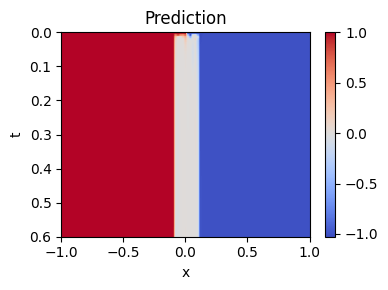

In [46]:
# Visualize PINNs 
X_SIZE = 101
T_SIZE = 101

res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

mat = scipy.io.loadmat('./burgers.mat')
u = mat['u'].reshape(X_SIZE, T_SIZE)

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()
pred = pred.reshape(X_SIZE, T_SIZE)

print(pred.shape)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))
print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

L2re = L2RE(torch.tensor(u), torch.tensor(pred)).mean()
MaxE = MaxError(torch.tensor(u), torch.tensor(pred)).mean()
Mse = MSE(torch.tensor(u), torch.tensor(pred)).mean()
Rmse = RMSE(torch.tensor(u), torch.tensor(pred)).mean()
print("MSE: ", Mse.detach().cpu().numpy())
print("RMSE: ", Rmse.detach().cpu().numpy())
print("L2RE: ", L2re.detach().cpu().numpy())
print("MaxE: ", MaxE.detach().cpu().numpy())


plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Prediction')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/ga_pinn_pred.png')
plt.show()

# relative L1 error: 0.046801
# relative L2 error: 0.151278
# MSE:  0.013141892
# RMSE:  0.026875637
# L2RE:  1.0096555
# MaxE:  0.133943

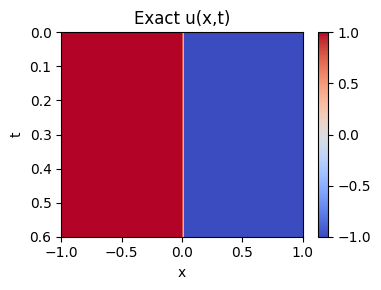

In [47]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/exact.png')
plt.show()

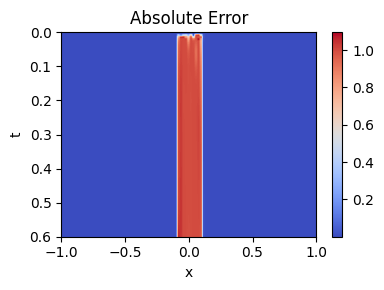

In [48]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/GApinns_error.png')
plt.show()

(101, 101)


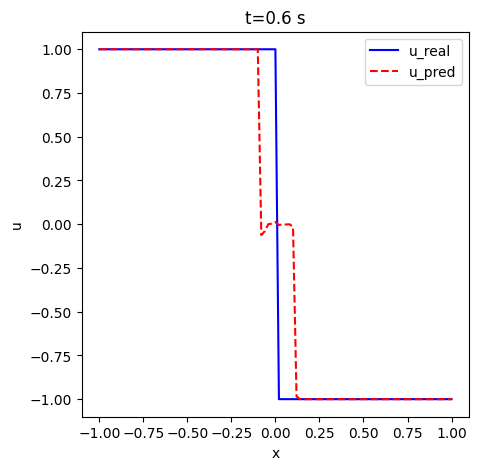

In [49]:
# 绘制t时刻的折线图
print(u.shape)
import matplotlib.pyplot as plt
import numpy as np

# 假设的时间序列数据
x = np.linspace(-1, 1, 101)
u_real = u[-1, :]  # 实际值，例如使用正弦波
u_pred = pred[-1, :]  # 预测值，添加一些噪声

plt.figure(figsize=(5, 5))
plt.plot(x, u_real, label='u_real', color='blue')  # 实际值曲线
plt.plot(x, u_pred, label='u_pred', color='red', linestyle='--')  # 预测值曲线

plt.title('t=0.6 s')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(False)
plt.savefig('./image/GApinns_0.6.png')
plt.show()
